In [43]:
import sys
try:
    del sys.modules["spnhelp"]
except:
    pass
import spnhelp
try:
    del sys.modules["clg_revised_revised"]
except:
    pass
from clg_revised_revised import Node, Distribution as dist, ParentList as pa
from math import sqrt
from spn.io.Text import spn_to_str_equation
import pandas as pd
from spn.structure.leaves.parametric.Parametric import Gaussian, Uniform
import numpy as np
import matplotlib.pyplot as plt
from spn.algorithms.Marginalization import marginalize
from spn.algorithms.Inference import likelihood 
import scipy.stats as stats
import torch
from IPython.display import display

### Developing a nice PGM syntax
It's a graph. We build it from the root.
 - Roots just needs their distribution and a name.
 - The rest needs its conditional distribution given its parents, its parents, and a name

In [44]:
gauss_pdf = lambda x: np.exp(-x**2)

A = "A" > dist(gauss_pdf)
B = "B" |  pa(A) > dist(gauss_pdf)
C = "C" |  pa(A) > dist(gauss_pdf)
D = "D" | pa(B, C) > dist(gauss_pdf)

K = "K" > dist(gauss_pdf)

A & K

A.set_evidence(2)
print(A.get_roots())
print(A.partition_by_connected_components())

[B|A=2, C|A=2]
self: A
r B|A=2
L [B|A=2]
S []
r C|A=2
L [C|A=2]
S []
self: K
r K
L [K]
S []
[[B|A=2], [C|A=2], [K]]


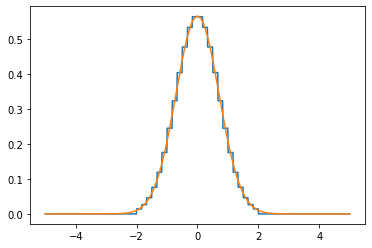

In [45]:
from spn.structure.Base import Node, Sum, Product, assign_ids, rebuild_scopes_bottom_up

def disc_fun(func, num:int, bounds, normalize = True,scope= 0):
    children = []
    weights = []
    for start, mid, end, weight in spnhelp.general_discretization_params(func, num=num, bounds=bounds , normalize=normalize):        
        children += Uniform(start=start, end=end, scope=scope),
        weights += weight,

    s = Sum(children=children, weights=weights)
    assign_ids(s)
    rebuild_scopes_bottom_up(s)

    return s

spn = disc_fun(gauss_pdf, num = 25, bounds=(-2,2), normalize=True)
x = np.linspace(-5, 5, 1000)

plt.plot(x, likelihood(spn, x.reshape(-1, 1)));
plt.plot(x, gauss_pdf(x)/sqrt(np.pi));

In [46]:
from itertools import product

def pgm_to_spn(pgm : Node, num = 10, name_map = None):

    # name mapping:
    rebuild_scope = (name_map == None)
    if name_map == None:
        name_map = {name : i for i, name in enumerate(pgm.get_scope(across_factors = True))}

    root_clusters = pgm.partition_by_connected_components()
    
    global_factors = []

    for p in root_clusters:
        roots = list(p)

        if len(roots) == 1 and roots[0].children == []:
            print("[] making a gaussian leaf from", roots[0].name)
            global_factors.append(Gaussian(mean=0, stdev=1, scope = name_map[roots[0].name])) #! fix this

        else:            
            discs = [spnhelp.general_discretization_params(n.cond_dist, num=num, bounds=(-5,5)) for n in roots]
            print("[] discretizing", [r.name for r in roots])#, "and generating cartesian product of size", np.prod([len(d) for d in discs]))
            
            summands = []
            sum_weights = []

            for cell in product(*discs): # for each possible assignment of the cells of the roots (cartesian product)
                sub_factor = []
                sum_weight = 1
                
                print(cell)
                for i, dim in enumerate(cell): # condition each root on the assignment

                    start, mid, end, weight = dim
                    print("[] set", roots[i].name, "to", dim[1])

                    roots[i].set_evidence(mid)

                    sub_factor += Uniform(start=start, end=end, scope = name_map[copy.get_roots()[i].name]),
                    sum_weight *= weight
            
                # now, get the pgm of the children.
                child = roots[0].castrate_roots()
                sub_factor += pgm_to_spn(roots[0], num=num, name_map = name_map),

                summands += Product(children = sub_factor),
                sum_weights += sum_weight,

                for r in roots:
                    r.set_evidence(None)
                              
            s = Sum(children = summands, weights = sum_weights)

            global_factors.append(s)


    prod = Product(global_factors)

    if rebuild_scope:
        assign_ids(prod)
        rebuild_scopes_bottom_up(prod)
    
    return prod

spn = pgm_to_spn(A)

self: A
r B|A=2
L [B|A=2]
S []
r C|A=2
L [C|A=2]
S []
self: K
r K
L [K]
S []
[] discretizing ['B']
((-5.0, -4.444444444444445, -3.888888888888889, 1.6528490744941915e-09),)
[] set B to -4.444444444444445


NameError: name 'copy' is not defined